In [1]:
# %matplotlib notebook # comment this line when working in VSCode
import aipy, uvtools
import numpy as np
import pylab as plt
import random
import math

from hera_sim import foregrounds, noise, sigchain, rfi

In [21]:
# from jupyterthemes import jtplot
# jtplot.style('grade3')

In [53]:
def get_k_rand_nums(start, stop, k):
    return sorted([random.uniform(start, stop) for x in range(k)])

def plot_one_vis(vis, ylim):
    plt.figure()
    plt.subplot(211); uvtools.plot.waterfall(vis, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,ylim)
    plt.subplot(212); uvtools.plot.waterfall(vis, mode='phs'); plt.colorbar(); plt.ylim(0,ylim)
    plt.show()

MX, DRNG = 2.5, 3


# Generate a waterfall plot
Stored in `vis`

In [5]:
# ORIGINAL
lsts = np.linspace(0,2*np.pi,4000, endpoint=False) # local sidereal times; start range, stop range, number of snapshots
fqs = np.linspace(.1,.2,1024,endpoint=False) # frequencies in GHz
# times = lsts / (2*np.pi) * aipy.const.sidereal_day 
bl_len_ns = np.array([30.,0,0]) # ENU coordinates

### Generate point source foreground

In [6]:
# foregrounds.pntsrc_foreground?

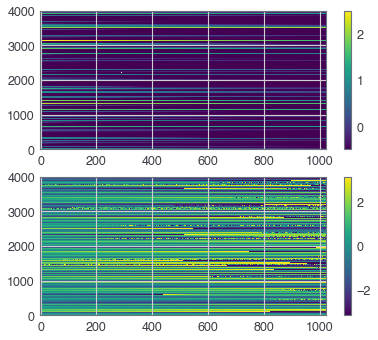

In [7]:
vis = foregrounds.pntsrc_foreground(lsts, fqs, bl_len_ns, nsrcs=200)

plot_one_vis(vis, 4000)

In [8]:
vis.shape

(4000, 1024)

### Generate diffuse source foreground

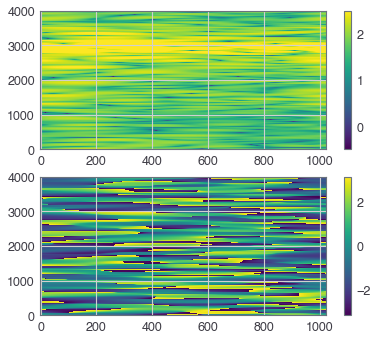

In [9]:
# bl_len_ns = np.array([30.])
Tsky_mdl = noise.HERA_Tsky_mdl['xx']
vis = vis + foregrounds.diffuse_foreground(lsts, fqs, bl_len_ns, Tsky_mdl) # add diffuse FG

MX, DRNG = 2.5, 3
plot_one_vis(vis, 4000)

### Generate and shuffle RFI

In [10]:
# rfi.rfi_stations?

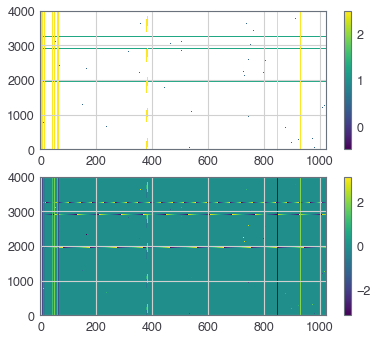

In [23]:
rfi1 = rfi.rfi_stations(fqs, lsts) # Default list of stations: rfi.HERA_RFI_STATIONS
rfi2 = rfi.rfi_impulse(fqs, lsts, chance=.02) # ORIGINAL: .02
rfi3 = rfi.rfi_scatter(fqs, lsts, chance=.001) # ORIGINAL: .001
rfi_all = rfi1 + rfi2 + rfi3

plot_one_vis(rfi_all, 4000)


In [26]:
# This function will be called on an individual waterfall plot
def add_random_rfi(plot):
    np.random.shuffle(rfi_all.T)
    return plot + rfi_all

### Generate noise
Should have variations!

In [13]:
# noise.sky_noise_jy?

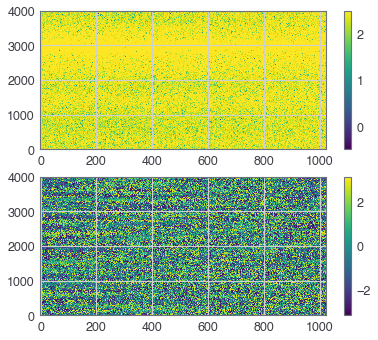

In [24]:
tsky = noise.resample_Tsky(fqs,lsts,Tsky_mdl=noise.HERA_Tsky_mdl['xx'])
t_rx = 150.
OMEGA_P = (0.72)*np.ones(1024) 
# .72 or smaller for omega_p; provided by Adrian, from literature

nos_jy = noise.sky_noise_jy(tsky + t_rx, fqs, lsts, OMEGA_P)
vis = vis + nos_jy
plot_one_vis(vis, 4000)

### Gain and Crosstalk

In [15]:
#####################
# TO BE ADDED
#####################

# Generate dataset

Layer one waterfall plot with `m` different RFI shuffles, then split each version (including the original untainted plot) into `l` data points, for a total dataset size of `(m+1)*l`.

In [45]:
l = 20 # number of divisions in each waterfall plot
m = 5

# Split clean plot and add to dataset
vis_dataset = np.split(vis, l) 
dataset = vis_dataset # add data points
zeros = np.zeros(l, dtype=int)
labels = zeros # add labels

# Add m different RFI shuffles, then split and add to dataset
for j in range(m):
    temp = add_random_rfi(vis)
    dataset = np.concatenate((dataset, np.split(temp, l)))
    labels = np.concatenate((labels, np.ones(l, dtype=int)))

# Export data
np.save('dataset.npy', dataset)
np.save('labels.npy', labels)

In [50]:
# Check a particular plot
# plot_one_vis(dataset[11], 4000/l) 

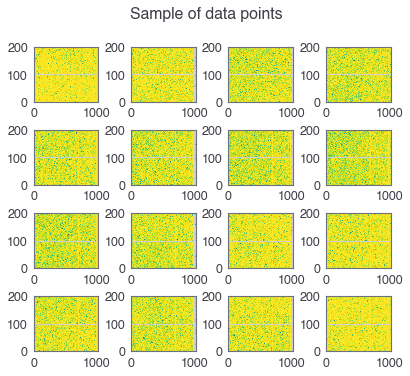

In [49]:
# Check multiple plots
j = 4 # dimensions of subplots
l1 = 16 # number of plots to print

# SHOW LOG PLOTS
fig = plt.figure()
fig.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Sample of data points")
for i in range(l1):
    plt.subplot(j, j, i+1); uvtools.plot.waterfall(dataset[l1+i], mode='log', mx=MX, drng=DRNG); plt.ylim(0,4000/l);
    
# SHOW PHS PLOTS
# fig = plt.figure()
# fig.subplots_adjust(hspace=0.6, wspace=0.6)
# for i in range(l1):
#     plt.subplot(j, j, i+1); uvtools.plot.waterfall(dataset[i], mode='phs', mx=MX, drng=DRNG); plt.ylim(0,400);